# Notebook Containing the data generation, NN Modelling and Optimization Attempts for two windturbines

In [27]:
### Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from pyomo import environ
from pyomo.core import *
import pyomo.environ as pyo
import gurobipy

import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'DistCL_code'))
from distcl import distcl

## Load Data

In [28]:
# Load Data
data = pd.read_csv("data/two_turbine_simulation_data_var_wind_dir.csv")
data.head()

,x_turb2,y_turb2,wind_speed,wind_direction,turbulence_intensity,turbine1_power,turbine2_powers,farm_power
0,0.0,0.0,8.0,0.0,0.06,1753.954459,1753.954459,3507.908918
1,0.0,0.0,8.0,10.0,0.06,1753.954459,1753.954459,3507.908918
2,0.0,0.0,8.0,20.0,0.06,1753.954459,1753.954459,3507.908918
3,0.0,0.0,8.0,30.0,0.06,1753.954459,1753.954459,3507.908918
4,0.0,0.0,8.0,40.0,0.06,1753.954459,1753.954459,3507.908918


# Train NN and generate constraints

In [29]:
# Test/Train Split
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

val_ind = val_data.index
test_ind = test_data.index

In [30]:
# Retrain the model with the best parameters
cl_tool = distcl(X=data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]],#, "turbulence_intensity"]],
            y=data["farm_power"], n_preds=1, val_ind=val_ind, test_ind=test_ind)

model, preds_test, sd_test, y_test = cl_tool.train(n_hidden=1, n_nodes=2, iters=1, drop=0.05, learning_rate=1e-4)

DistFCNN(
  (lin_layers): ModuleList(
    (0): Linear(in_features=4, out_features=2, bias=True)
  )
  (output_mean_layer): Linear(in_features=2, out_features=1, bias=True)
  (output_sd_layer): Linear(in_features=2, out_features=1, bias=True)
  (droput_layers): ModuleList(
    (0): Dropout(p=0.05, inplace=False)
  )
)
cpu
epoch 0 loss 726182.0625
NN fitting process finished with a validation GAUSSIANNLL loss of 726182.0625 in epoch 0


In [31]:
cons = cl_tool.constraint_build(model)
cons.to_csv('inputs/constraints_twoturbines.csv')
cons = pd.read_csv('inputs/constraints_twoturbines.csv', index_col=0)
cons

,intercept,layer,node,node_0,node_1,node_2,node_3
0,-0.052886,0,0,-0.004479,0.268222,-0.415343,-0.361743
1,0.122121,0,1,-0.193063,0.134079,-0.017762,0.393859
0,-0.661003,1,0,-0.200669,-0.124639,NaN,NaN
0,0.035943,2,0,-0.460908,-0.281505,NaN,NaN


# Optimization Model



### Decision Variables
\( x \): x-coordinate of the second turbine relative to the first.
\( y \): y-coordinate of the second turbine relative to the first.

### **Objective Function**
$$ \max_{x, y} P(x, y) $$

### Constraints
$ x_{\min} \leq x \leq x_{\max} $
   
$ y_{\min} \leq y \leq y_{\max} $


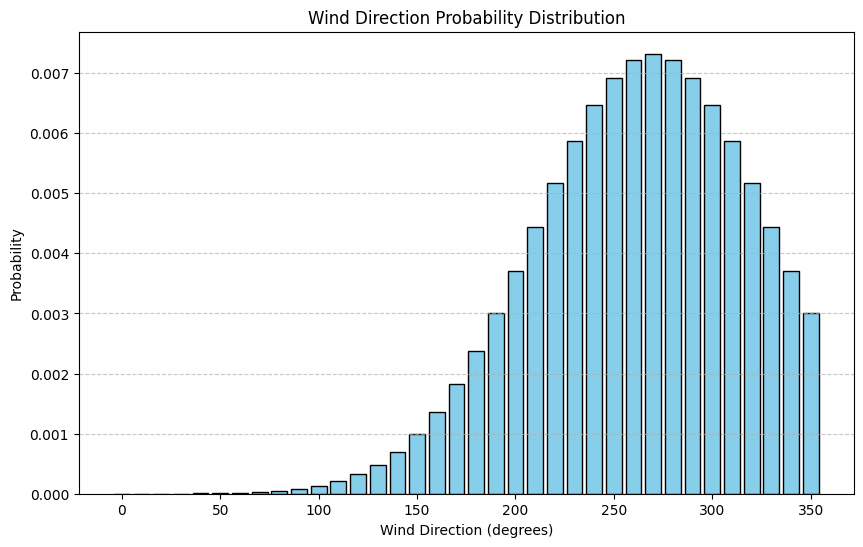

In [32]:
from scipy.stats import norm
import numpy as np

import matplotlib.pyplot as plt

# Parameters for the normal distribution
mean = 270
std_dev = 60  
x = np.arange(0, 360, 10)

# Generate the PDF and truncate 
pdf = norm.pdf(x, loc=mean, scale=std_dev)
pdf /= np.trapz(pdf, x)

# merge arrays
merged_array = np.column_stack((x, pdf))
wind_prob_dict = {int(row[0]): row[1] for row in merged_array}


# Plot the wind probability distribution
plt.figure(figsize=(10, 6))
plt.bar(wind_prob_dict.keys(), wind_prob_dict.values(), width=8, color='skyblue', edgecolor='black')
plt.xlabel('Wind Direction (degrees)')
plt.ylabel('Probability')
plt.title('Wind Direction Probability Distribution')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [33]:
#data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]]

contextual_sample_manual = pd.DataFrame({
    'x_turb2': ['Alice', 'Bob', 'Charlie'],
    'y_turb2': [25, 30, 35],
    'wind_speed': ['Paris', 'Berlin', 'Rome'],
    'wind_speed': ['Paris', 'Berlin', 'Rome']
})

contextual_sample_manual


,x_turb2,y_turb2,wind_speed
0,Alice,25,Paris
1,Bob,30,Berlin
2,Charlie,35,Rome


In [34]:
from pyomo.environ import ConcreteModel, Var, Objective, Constraint, SolverFactory, minimize, value

### Define the optimization model
model = ConcreteModel()

n_sc = 2
model.W = pyo.RangeSet(1,n_sc)
pi = [1/n_sc for i in range(n_sc)]


contextual_sample = data[["x_turb2", "y_turb2", "wind_speed", "wind_direction"]]#.iloc[[0]]
model.var_ind = pyo.Set(initialize=contextual_sample.columns.sort_values())

model.x = pyo.Var(model.var_ind, model.W ,within=pyo.Reals)
model.y = pyo.Var(pyo.Any, dense=False, domain=pyo.Reals) # learned variables (demand)

model.power = pyo.Var(model.W,within=pyo.Reals) # saving power per scenario


# obj function 
def obj_expression(model):
    return sum(pi[w-1] * model.power[w] for w in model.W)
model.OBJ = pyo.Objective(rule=obj_expression, sense=pyo.maximize)

#power generation
def power(model, w):
    return model.power[w] == model.y['power', 0, w]
model.const_power = pyo.Constraint(model.W, rule=power)

#constraint for fixing contextual information

# Fix other contextual variables
def fix_other_vars(model, x_ind, w):
    if x_ind not in ['x_turb2', 'y_turb2']:
        return model.x[x_ind, w] == contextual_sample.loc[w - 1, x_ind]
    return pyo.Constraint.Skip
model.const_fix_other_vars = pyo.Constraint(model.var_ind, model.W, rule=fix_other_vars)


# Constraint to ensure x_turb2 and y_turb2 are the same across all scenarios
def same_across_scenarios(model, var_name):
    first_scenario = next(iter(model.W))
    return (model.x[var_name, first_scenario] == model.x[var_name, w] for w in model.W if w != first_scenario)

model.const_same_x_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'x_turb2'):
    model.const_same_x_turb2.add(constraint)

model.const_same_y_turb2 = pyo.ConstraintList()
for constraint in same_across_scenarios(model, 'y_turb2'):
    model.const_same_y_turb2.add(constraint)



# ## min distance 
# # Define constraints if any (for example, minimum distance between turbines)
# def distance_constraint(model):
#     return ((model.x_turb2 - 0)**2 + (model.y_turb2 - 0)**2) >= 400**2 
# model.distance_constraint = Constraint(rule=distance_constraint)

### Constraint Embedding
cl_tool.const_embed_modified(opt_model=model, constaints=cons, outcome='power', deterministic = True, n_scenarios=n_sc)


1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')
1
Index(['wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'], dtype='object')


In [35]:
model.pprint()

1 Set Declarations
    var_ind : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'}

1 RangeSet Declarations
    W : Dimen=1, Size=2, Bounds=(1, 2)
        Key  : Finite : Members
        None :   True :   [1:2]

5 Var Declarations
    power : Size=2, Index=W
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :  None :  None :  None : False :  True :  Reals
          2 :  None :  None :  None : False :  True :  Reals
    v : Size=4, Index=Any
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
        ('power', 0, 0, 1) :     0 :  None :  None : False :  True : NonNegativeReals
        ('power', 0, 0, 2) :     0 :  None :  None : False :  True : NonNegativeReals
        ('power', 0, 1, 1) :     0 :  None :  None : False :  True : NonNegativeReals
        ('power', 0, 1, 2) :     0 :  None :  None : False :  True : 

In [36]:

# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmpxv58r309.pyomo.lp
Reading time = 0.00 seconds
x1: 26 rows, 26 columns, 80 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 26 rows, 26 columns and 80 nonzeros
Model fingerprint: 0x8d67b6f8
Variable types: 20 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  Objective range  [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 3e+03]
Presolve removed 18 rows and 20 columns
Presolve time: 0.00s
Presolved: 8 rows, 6 columns, 24 nonzeros
Variable types: 6 continuous, 0 integer (0 binary)

Root relaxation: objective 3.350591e+03, 2 ite

In [37]:
model.pprint()

1 Set Declarations
    var_ind : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    4 : {'wind_direction', 'wind_speed', 'x_turb2', 'y_turb2'}

1 RangeSet Declarations
    W : Dimen=1, Size=2, Bounds=(1, 2)
        Key  : Finite : Members
        None :   True :   [1:2]

5 Var Declarations
    power : Size=2, Index=W
        Key : Lower : Value              : Upper : Fixed : Stale : Domain
          1 :  None : 3350.5911692554605 :  None : False : False :  Reals
          2 :  None : 3350.5911692554605 :  None : False : False :  Reals
    v : Size=4, Index=Any
        Key                : Lower : Value : Upper : Fixed : Stale : Domain
        ('power', 0, 0, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        ('power', 0, 0, 2) :     0 :   0.0 :  None : False : False : NonNegativeReals
        ('power', 0, 1, 1) :     0 :   0.0 :  None : False : False : NonNegativeReals
        ('power', 0, 1, 2) :  

In [38]:
# print optimization results
print("\nOptimization Results:")

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")


Optimization Results:

Contextual/Decision Variables (x):
('wind_direction', 1): 0.0
('wind_direction', 2): 10.0
('wind_speed', 1): 8.0
('wind_speed', 2): 8.0
('x_turb2', 1): 3732.2937033221115
('x_turb2', 2): 3732.2937033221115
('y_turb2', 1): 94.4988418337002
('y_turb2', 2): 94.4988418337002


In [39]:

# Solve the optimization problem
solver = SolverFactory('gurobi')
solver.options['threads'] = 8
solver.options['NonConvex'] = 2
results = solver.solve(model, tee=True)

Read LP format model from file /var/folders/2j/t8d8dcsn1tg5sc8l4kz4_4ch0000gn/T/tmp0sz44ixj.pyomo.lp
Reading time = 0.00 seconds
x1: 26 rows, 26 columns, 80 nonzeros
Set parameter Threads to value 8
Set parameter NonConvex to value 2
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (mac64[x86] - Darwin 24.4.0 24E263)

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz
Thread count: 6 physical cores, 12 logical processors, using up to 8 threads

Non-default parameters:
NonConvex  2
Threads  8

Optimize a model with 26 rows, 26 columns and 80 nonzeros
Model fingerprint: 0x8d67b6f8
Variable types: 20 continuous, 6 integer (6 binary)
Coefficient statistics:
  Matrix range     [1e-05, 1e+03]
  Objective range  [5e-01, 5e-01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [4e-02, 3e+03]
Presolve removed 18 rows and 20 columns
Presolve time: 0.00s
Presolved: 8 rows, 6 columns, 24 nonzeros
Variable types: 6 continuous, 0 integer (0 binary)

Root relaxation: objective 3.350591e+03, 2 ite

In [40]:
# print optimization results
print("\nOptimization Results:")

# Print x variables (contextual features and decision variables)
print("\nContextual/Decision Variables (x):")
for k in model.x:
    print(f"{k}: {pyo.value(model.x[k])}")



Optimization Results:

Contextual/Decision Variables (x):
('wind_direction', 1): 0.0
('wind_direction', 2): 10.0
('wind_speed', 1): 8.0
('wind_speed', 2): 8.0
('x_turb2', 1): 3732.2937033221115
('x_turb2', 2): 3732.2937033221115
('y_turb2', 1): 94.4988418337002
('y_turb2', 2): 94.4988418337002


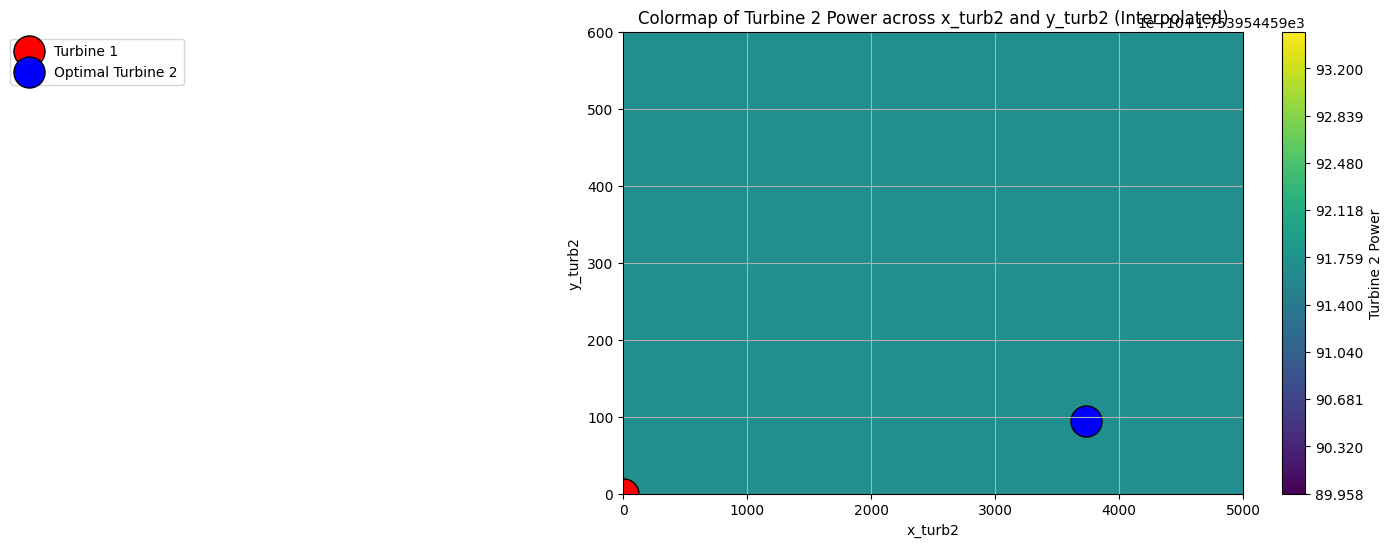

In [41]:
# Visualize the results
from scipy.interpolate import griddata




# Colormap with interpolation
x = data['x_turb2']
y = data['y_turb2']
z = data['turbine2_powers']
xi, yi = np.linspace(x.min(), x.max(), 100), np.linspace(y.min(), y.max(), 100)
xi, yi = np.meshgrid(xi, yi)
zi = griddata((x, y), z, (xi, yi), method='linear')

plt.figure(figsize=(10, 6))
plt.contourf(xi, yi, zi, levels=100, cmap='viridis')
plt.colorbar(label='Turbine 2 Power')

# Mark the position of wind turbine one
plt.scatter(0, 0, color='red', label='Turbine 1', s=500, edgecolor='black')

# Mark the position of the optimal location of wind turbine 2
optimal_x = pyo.value(model.x['x_turb2',1])
optimal_y = pyo.value(model.x['y_turb2',1])
plt.scatter(optimal_x, optimal_y, color='blue', label='Optimal Turbine 2', s=500, edgecolor='black')

plt.legend(loc='upper left', bbox_to_anchor=(-1, 1))

# cosmetics 
plt.xlabel('x_turb2')
plt.ylabel('y_turb2')
plt.title('Colormap of Turbine 2 Power across x_turb2 and y_turb2 (Interpolated)')
plt.grid(True)
plt.show()
